In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.applications import ResNet152V2, MobileNetV2, InceptionV3, VGG16
from tensorflow.keras.models import load_model
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [2]:
# Functions
def loss_acc_fig(history):
    fig = plt.figure(figsize = [20,7])
    fig.add_subplot(1,2,1); plt.plot(history.history['loss'], color='#2F70AF', label='loss'); plt.plot(history.history['val_loss'], color='#e77d01', label='val_loss'); plt.legend(loc="upper left"); plt.title('Loss', fontsize=20);
    fig.add_subplot(1,2,2); plt.plot(history.history['accuracy'], color='#724C9D', label='accuracy'); plt.plot(history.history['val_accuracy'], color='#FB7488', label='val_accuracy'); plt.legend(loc="upper left"); plt.title('Accuracy', fontsize=20);
    plt.show()

def confusion_mat(model):
    df_comb = pd.DataFrame()
    for batch in test.as_numpy_iterator(): 
        x,y = batch
        yhat = model.predict(x).argmax(axis=1)
        y_out = y.argmax(axis=1)
        df = pd.DataFrame({'y': y_out.flatten(), 'yhat': yhat.flatten()})
        df_comb = pd.concat([df_comb, df])

    cf = confusion_matrix(df_comb.y, df_comb.yhat)
    print(cf)
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Crack', 'Potholes', 'Ruts'])
    ax.yaxis.set_ticklabels(['Crack', 'Potholes', 'Ruts'])
    
    print(classification_report(df_comb.y, df_comb.yhat))

### Prevent OOM

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Data loading

In [4]:
train = tf.keras.utils.image_dataset_from_directory('road_images/split/train', batch_size=64, image_size=(224, 224)) 
train_iterator = train.as_numpy_iterator()
train_batch = train_iterator.next() 

dev = tf.keras.utils.image_dataset_from_directory('road_images/split/dev', batch_size=64, image_size=(224, 224)) 
dev_iterator = dev.as_numpy_iterator()
dev_batch = dev_iterator.next() 

test = tf.keras.utils.image_dataset_from_directory('road_images/split/test', batch_size=64, image_size=(224, 224)) 
test_iterator = test.as_numpy_iterator()
test_batch = test_iterator.next() 

Found 2654 files belonging to 3 classes.
Metal device set to: Apple M1


2023-08-07 10:39:34.953982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-07 10:39:34.954348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 498 files belonging to 3 classes.
Found 167 files belonging to 3 classes.


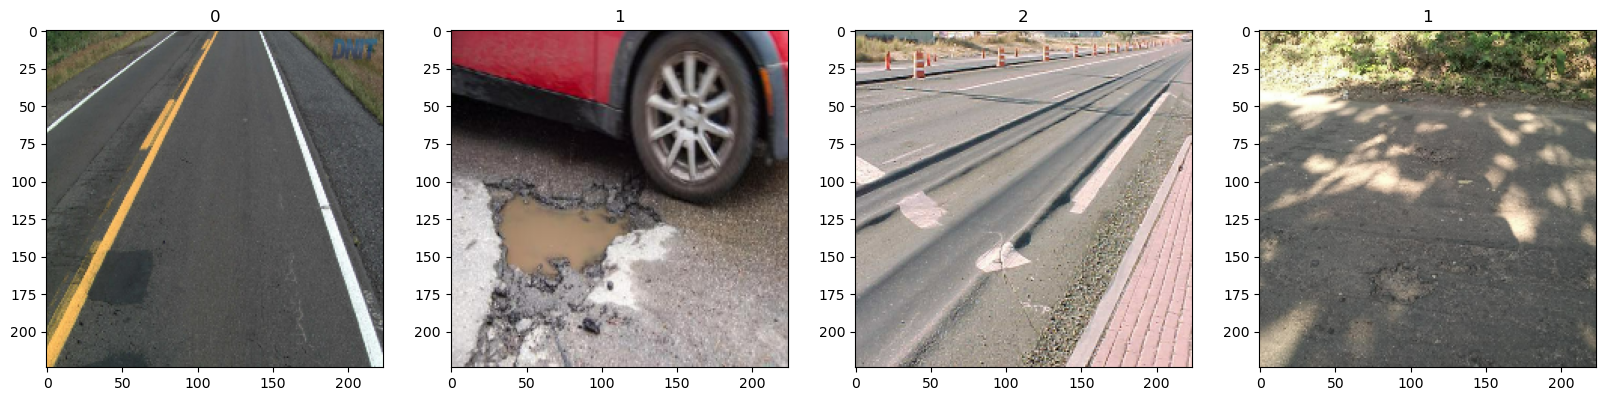

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(test_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(test_batch[1][idx])

### Data scaling

In [5]:
train = train.map(lambda x,y: (x/255, tf.one_hot(y, 3)))
dev = dev.map(lambda x,y: (x/255, tf.one_hot(y, 3)))
test = test.map(lambda x,y: (x/255, tf.one_hot(y, 3)))
test.as_numpy_iterator().next()

(array([[[[0.3190176 , 0.38176268, 0.33862543],
          [0.29924968, 0.35023007, 0.31493595],
          [0.3313625 , 0.37449974, 0.35097033],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[0.597429  , 0.64840937, 0.6091937 ],
          [0.3012405 , 0.3522209 , 0.3247699 ],
          [0.7253801 , 0.7763605 , 0.7410664 ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[0.9120348 , 0.97085834, 0.89634854],
          [0.7448378 , 0.7879751 , 0.7566025 ],
          [0.44476798, 0.48790523, 0.49574837],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[0.5143897 , 0.502625  , 0.46733084],
          [0.44472

### Modeling

### MobileNetv2

In [6]:
mobnet_conv = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

In [7]:
mobnet_conv.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [53]:
for layer in mobnet_conv.layers:
    if layer in mobnet_conv.layers[-3:]:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
mobnet_conv.layers[-5:]

In [74]:
mobnet_conv.trainable = False

In [116]:
mobnet_conv.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [117]:
mobnet_model = Sequential()

mobnet_model.add(mobnet_conv)

mobnet_model.add(GlobalAveragePooling2D())
mobnet_model.add(Dense(128, activation = 'relu'))
mobnet_model.add(Dropout(0.4))
mobnet_model.add(Dense(3, activation = 'softmax'))

mobnet_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_29 (Dense)            (None, 128)               163968    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 164

In [118]:
mobnet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.000005),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [119]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose= 1, restore_best_weights=True)

In [120]:
history_mobnet = mobnet_model.fit(train, epochs=30, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/30


2023-08-07 16:18:05.800735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.5464 - accuracy: 0.3350

2023-08-07 16:18:25.094376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 26s 484ms/step - loss: 1.5464 - accuracy: 0.3350 - val_loss: 1.2315 - val_accuracy: 0.4277
Epoch 2/30
42/42 [==============================] - 17s 357ms/step - loss: 1.3239 - accuracy: 0.3922 - val_loss: 1.0293 - val_accuracy: 0.5120
Epoch 3/30
42/42 [==============================] - 17s 343ms/step - loss: 1.1223 - accuracy: 0.4714 - val_loss: 0.8689 - val_accuracy: 0.6145
Epoch 4/30
42/42 [==============================] - 17s 340ms/step - loss: 0.9551 - accuracy: 0.5539 - val_loss: 0.7411 - val_accuracy: 0.7149
Epoch 5/30
42/42 [==============================] - 17s 344ms/step - loss: 0.8383 - accuracy: 0.6164 - val_loss: 0.6400 - val_accuracy: 0.7912
Epoch 6/30
42/42 [==============================] - 17s 345ms/step - loss: 0.7353 - accuracy: 0.6680 - val_loss: 0.5578 - val_accuracy: 0.8474
Epoch 7/30
42/42 [==============================] - 17s 344ms/step - loss: 0.6460 - accuracy: 0.7257 - val_loss: 0.4923 - val_accuracy: 0.8795
Epoch 8/30

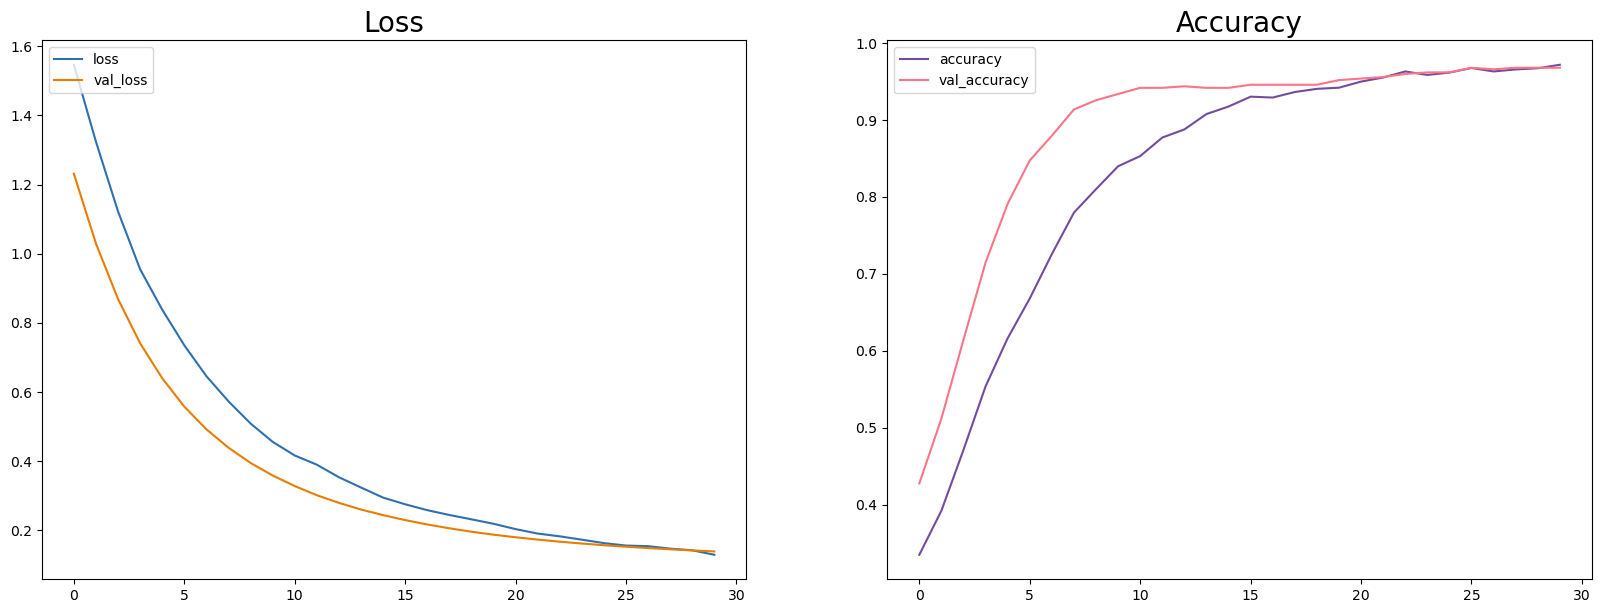

In [121]:
loss_acc_fig(history_mobnet)

2023-08-07 16:27:01.614670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 17ms/step


2023-08-07 16:27:04.030209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step
[[57  0  3]
 [ 0 61  1]
 [ 0  0 45]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       1.00      0.98      0.99        62
           2       0.92      1.00      0.96        45

    accuracy                           0.98       167
   macro avg       0.97      0.98      0.97       167
weighted avg       0.98      0.98      0.98       167



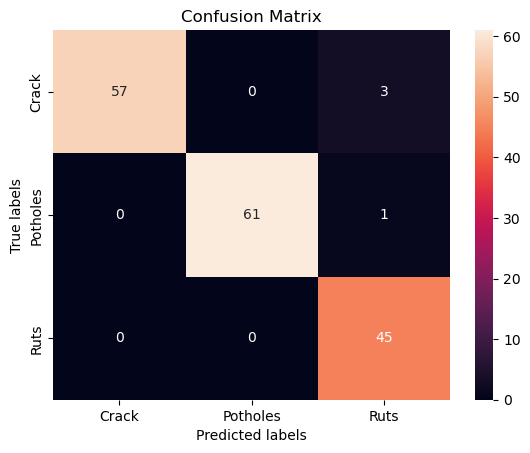

In [122]:
confusion_mat(mobnet_model)

### ResNet152v2

In [89]:
resnet_conv = ResNet152V2(include_top=False, weights='imagenet')

In [90]:
resnet_conv.trainable = True
resnet_conv.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                        

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, None, None, 256)      0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, None, None, 64)       16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, None, None, 64)       256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, None, None, 128)      0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, None, None, 128)      147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, None, None, 512)      0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, None, None, 512)      2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, None, None, 512)      0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, None, None, 128)      0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, None, None, 128)      147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, None, None, 1024)     525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, None, None, 1024)     263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, None, None, 1024)     0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, None, None, 256)      0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, None, None, 256)      0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, None, None, 1024)     263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, None, None, 1024)     0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, None, None, 256)      0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, None, None, 256)      0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, None, None, 256)      589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, None, None, 1024)     263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, None, None, 1024)     0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, None, None, 1024)     263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, None, None, 1024)     0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, None, None, 1024)     0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, None, None, 1024)     0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, None, None, 1024)     0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, None, None, 1024)     0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, None, None, 1024)     0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, None, None, 1024)     0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, None, None, 1024)     0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, None, None, 256)      262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, None, None, 1024)     0         ['max_pooling2d_2[0][0]',     
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, None, None, 1024)     0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, None, None, 512)      2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, None, None, 512)      0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, None, None, 512)      2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

In [91]:
resnet_conv.layers[-4:]

In [92]:
for layer in resnet_conv.layers:
    if layer in resnet_conv.layers[-4:]:
        layer.trainable = True
    else:
        layer.trainable = False

In [93]:
resnet_conv.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                        

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, None, None, 256)      0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, None, None, 64)       16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, None, None, 64)       256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, None, None, 128)      0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, None, None, 128)      147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, None, None, 512)      0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, None, None, 512)      2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, None, None, 512)      0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, None, None, 128)      0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, None, None, 128)      147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, None, None, 1024)     525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, None, None, 1024)     263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, None, None, 1024)     0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, None, None, 256)      0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, None, None, 256)      0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, None, None, 1024)     263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, None, None, 1024)     0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, None, None, 256)      0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, None, None, 256)      0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, None, None, 256)      589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, None, None, 1024)     263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, None, None, 1024)     0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, None, None, 1024)     263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, None, None, 1024)     0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, None, None, 1024)     0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, None, None, 1024)     0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, None, None, 1024)     0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, None, None, 1024)     0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, None, None, 1024)     0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, None, None, 1024)     0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, None, None, 1024)     0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, None, None, 256)      262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, None, None, 1024)     0         ['max_pooling2d_2[0][0]',     
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, None, None, 1024)     0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, None, None, 512)      2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, None, None, 512)      0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, None, None, 512)      2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

In [94]:
resnet_model = Sequential()

resnet_model.add(resnet_conv)

resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(256, activation = 'relu'))
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(128, activation = 'relu'))
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(3, activation = 'softmax'))

resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_26 (Dense)            (None, 256)               524544    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)             

In [95]:
resnet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.000005),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [96]:
history_resnet = resnet_model.fit(train, epochs=40, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/40


2023-08-07 14:18:40.048929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.2858 - accuracy: 0.3402

2023-08-07 14:19:53.516203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 94s 2s/step - loss: 1.2858 - accuracy: 0.3402 - val_loss: 1.0832 - val_accuracy: 0.3534
Epoch 2/40
42/42 [==============================] - 74s 2s/step - loss: 1.1244 - accuracy: 0.4277 - val_loss: 0.9431 - val_accuracy: 0.5743
Epoch 3/40
42/42 [==============================] - 75s 2s/step - loss: 1.0393 - accuracy: 0.4970 - val_loss: 0.8463 - val_accuracy: 0.7149
Epoch 4/40
42/42 [==============================] - 77s 2s/step - loss: 0.9428 - accuracy: 0.5757 - val_loss: 0.7740 - val_accuracy: 0.7851
Epoch 5/40
42/42 [==============================] - 82s 2s/step - loss: 0.8825 - accuracy: 0.6225 - val_loss: 0.7171 - val_accuracy: 0.8072
Epoch 6/40
42/42 [==============================] - 89s 2s/step - loss: 0.8350 - accuracy: 0.6537 - val_loss: 0.6701 - val_accuracy: 0.8333
Epoch 7/40
42/42 [==============================] - 79s 2s/step - loss: 0.7876 - accuracy: 0.6699 - val_loss: 0.6307 - val_accuracy: 0.8454
Epoch 8/40
42/42 [=============

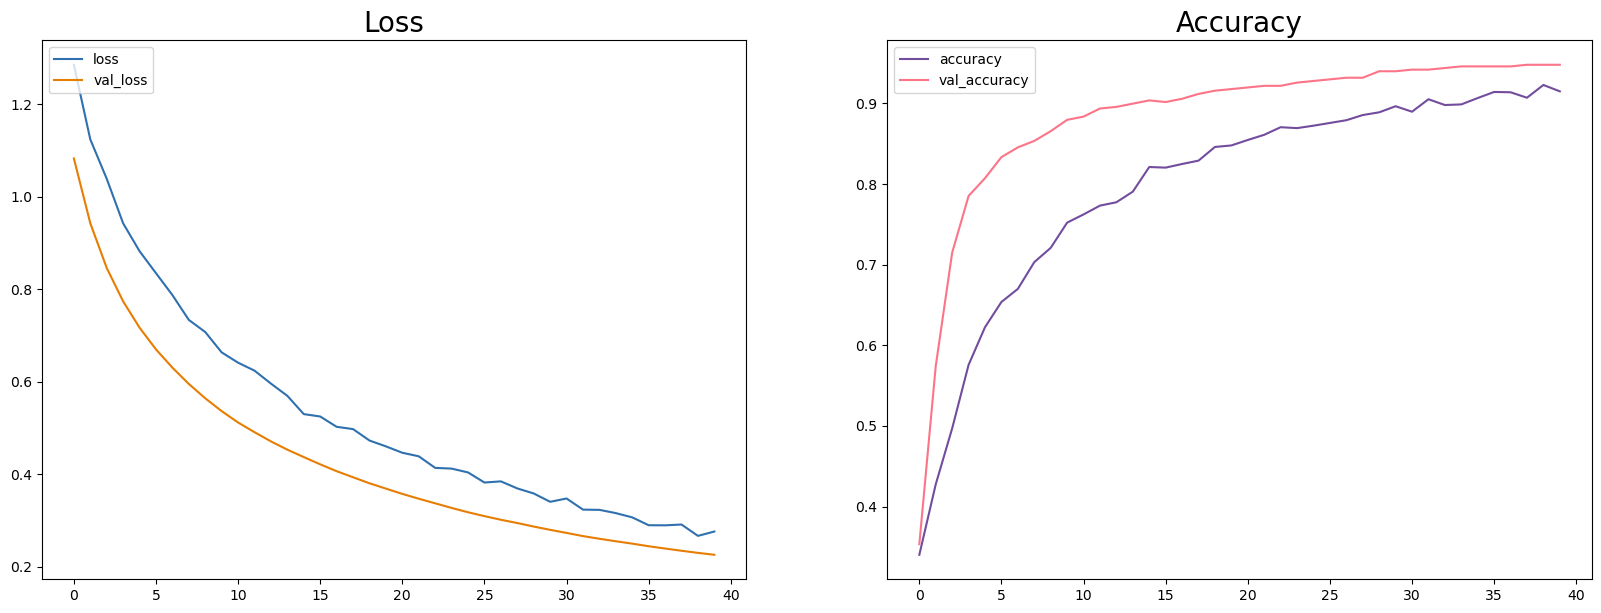

In [97]:
loss_acc_fig(history_resnet)

In [107]:
resnet_model.fit(train, epochs=3, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/3
42/42 [==============================] - 78s 2s/step - loss: 0.1578 - accuracy: 0.9525 - val_loss: 0.1465 - val_accuracy: 0.9558
Epoch 2/3
42/42 [==============================] - 75s 2s/step - loss: 0.1443 - accuracy: 0.9582 - val_loss: 0.1451 - val_accuracy: 0.9578
Epoch 3/3
42/42 [==============================] - 76s 2s/step - loss: 0.1433 - accuracy: 0.9597 - val_loss: 0.1435 - val_accuracy: 0.9558


In [109]:
resnet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.000001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [113]:
resnet_model.fit(train, epochs=3, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/3
42/42 [==============================] - 79s 2s/step - loss: 0.1367 - accuracy: 0.9612 - val_loss: 0.1418 - val_accuracy: 0.9578
Epoch 2/3
42/42 [==============================] - 75s 2s/step - loss: 0.1353 - accuracy: 0.9597 - val_loss: 0.1415 - val_accuracy: 0.9578
Epoch 3/3
42/42 [==============================] - 75s 2s/step - loss: 0.1454 - accuracy: 0.9597 - val_loss: 0.1412 - val_accuracy: 0.9578


2/2 [==============================] - 3s 1s/step
[[56  1  3]
 [ 0 62  0]
 [ 0  3 42]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.94      1.00      0.97        62
           2       0.93      0.93      0.93        45

    accuracy                           0.96       167
   macro avg       0.96      0.96      0.96       167
weighted avg       0.96      0.96      0.96       167



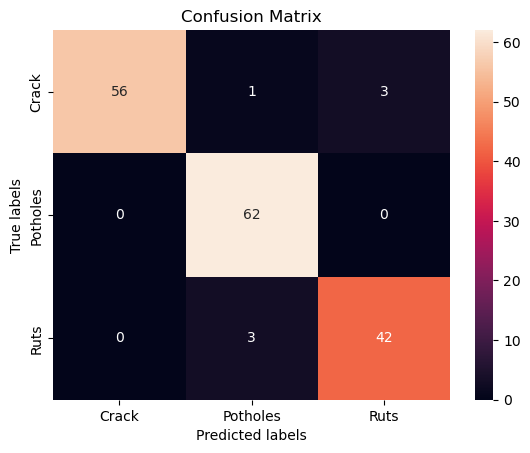

In [115]:
confusion_mat(resnet_model)

### Inceptionv3

In [123]:
incept_conv = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(224,224,3))

In [124]:
incept_conv.trainable = False
incept_conv.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [125]:
incept_model = Sequential()

incept_model.add(incept_conv)

incept_model.add(GlobalAveragePooling2D())
incept_model.add(Dense(256, activation = 'relu'))
incept_model.add(Dropout(0.4))
incept_model.add(Dense(128, activation = 'relu'))
incept_model.add(Dropout(0.4))
incept_model.add(Dense(3, activation = 'softmax'))

incept_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_31 (Dense)            (None, 256)               524544    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                     

In [126]:
incept_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.00002),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [127]:
history_incept = incept_model.fit(train, epochs=40, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/40


2023-08-07 16:28:12.566223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.2517 - accuracy: 0.4081

2023-08-07 16:28:37.747995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 36s 713ms/step - loss: 1.2517 - accuracy: 0.4081 - val_loss: 0.9665 - val_accuracy: 0.5502
Epoch 2/40
42/42 [==============================] - 23s 495ms/step - loss: 0.9410 - accuracy: 0.5622 - val_loss: 0.8011 - val_accuracy: 0.6988
Epoch 3/40
42/42 [==============================] - 22s 472ms/step - loss: 0.8384 - accuracy: 0.6183 - val_loss: 0.7132 - val_accuracy: 0.7269
Epoch 4/40
42/42 [==============================] - 22s 463ms/step - loss: 0.7360 - accuracy: 0.6756 - val_loss: 0.6347 - val_accuracy: 0.7590
Epoch 5/40
42/42 [==============================] - 22s 477ms/step - loss: 0.6949 - accuracy: 0.7050 - val_loss: 0.5819 - val_accuracy: 0.7892
Epoch 6/40
42/42 [==============================] - 22s 463ms/step - loss: 0.6282 - accuracy: 0.7411 - val_loss: 0.5408 - val_accuracy: 0.8112
Epoch 7/40
42/42 [==============================] - 22s 469ms/step - loss: 0.5903 - accuracy: 0.7524 - val_loss: 0.4873 - val_accuracy: 0.8394
Epoch 8/40

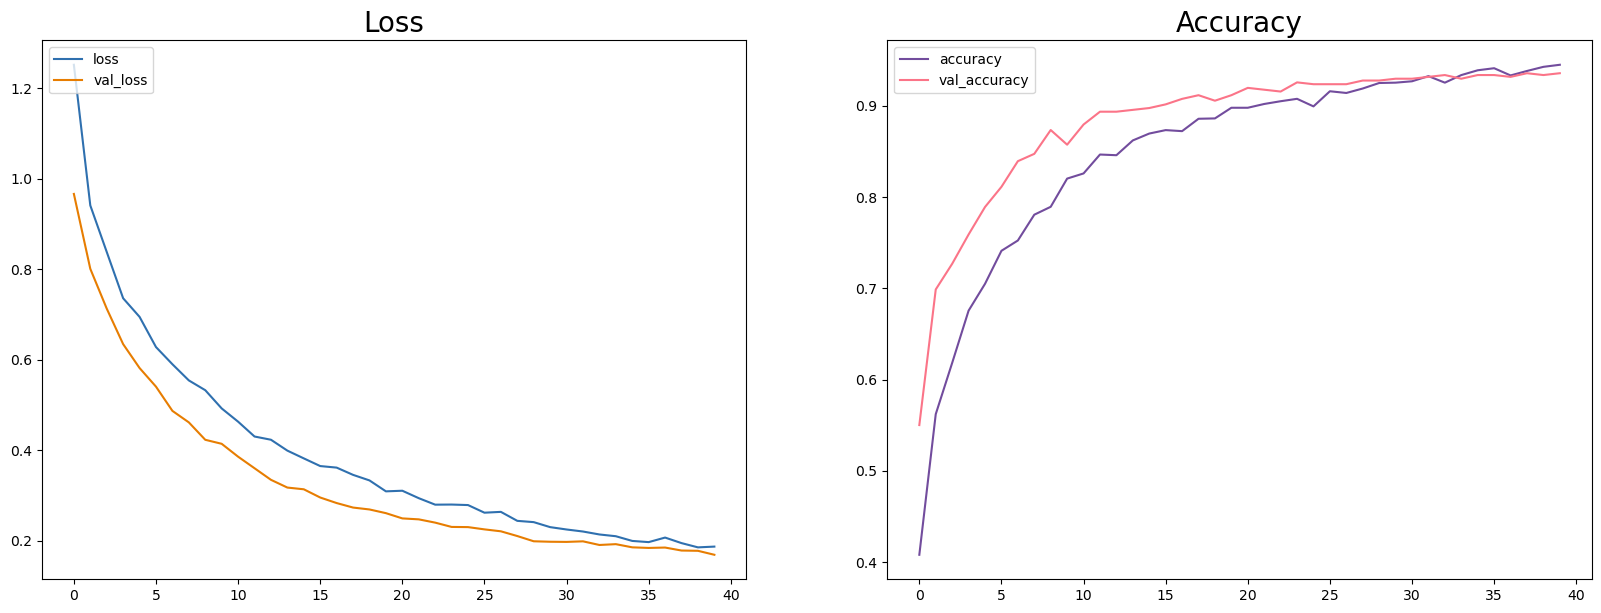

In [128]:
loss_acc_fig(history_incept)

In [132]:
incept_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.000005),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])
history_incept2 = incept_model.fit(train, epochs=5, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/5


2023-08-07 17:16:37.401499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9442

2023-08-07 17:17:04.167607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 39s 767ms/step - loss: 0.1835 - accuracy: 0.9442 - val_loss: 0.1703 - val_accuracy: 0.9357
Epoch 2/5
42/42 [==============================] - 25s 550ms/step - loss: 0.1769 - accuracy: 0.9454 - val_loss: 0.1686 - val_accuracy: 0.9357
Epoch 3/5
42/42 [==============================] - 25s 546ms/step - loss: 0.1787 - accuracy: 0.9412 - val_loss: 0.1671 - val_accuracy: 0.9357
Epoch 4/5
42/42 [==============================] - 22s 480ms/step - loss: 0.1756 - accuracy: 0.9465 - val_loss: 0.1679 - val_accuracy: 0.9378
Epoch 5/5
42/42 [==============================] - 27s 590ms/step - loss: 0.1736 - accuracy: 0.9446 - val_loss: 0.1644 - val_accuracy: 0.9378


2023-08-07 17:20:56.288149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 657ms/step


2023-08-07 17:21:03.430312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 8s 2s/step
[[54  1  5]
 [ 1 60  1]
 [ 0  2 43]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        60
           1       0.95      0.97      0.96        62
           2       0.88      0.96      0.91        45

    accuracy                           0.94       167
   macro avg       0.94      0.94      0.94       167
weighted avg       0.94      0.94      0.94       167



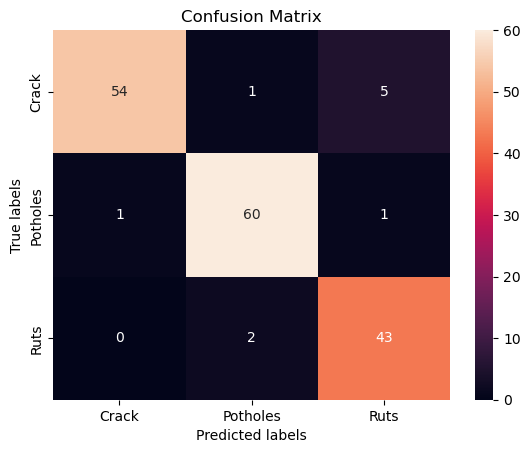

In [133]:
confusion_mat(incept_model)

### VGG16

In [134]:
vgg_conv = VGG16(weights = 'imagenet', include_top = False)

In [135]:
vgg_conv.trainable = False
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [142]:
vgg_model = Sequential()

vgg_model.add(vgg_conv)

vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(128, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(3, activation = 'softmax'))

vgg_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                     

In [143]:
vgg_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.00005),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [144]:
history_vgg = vgg_model.fit(train, epochs=40, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/40


2023-08-07 18:43:50.456306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.3775

2023-08-07 18:44:45.868465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 68s 2s/step - loss: 1.1196 - accuracy: 0.3775 - val_loss: 1.0408 - val_accuracy: 0.6787
Epoch 2/40
42/42 [==============================] - 62s 1s/step - loss: 1.0579 - accuracy: 0.4567 - val_loss: 0.9883 - val_accuracy: 0.6647
Epoch 3/40
42/42 [==============================] - 61s 1s/step - loss: 0.9895 - accuracy: 0.5399 - val_loss: 0.9223 - val_accuracy: 0.6807
Epoch 4/40
42/42 [==============================] - 61s 1s/step - loss: 0.9345 - accuracy: 0.5987 - val_loss: 0.8532 - val_accuracy: 0.6888
Epoch 5/40
42/42 [==============================] - 60s 1s/step - loss: 0.8678 - accuracy: 0.6398 - val_loss: 0.7811 - val_accuracy: 0.6847
Epoch 6/40
42/42 [==============================] - 60s 1s/step - loss: 0.8080 - accuracy: 0.6654 - val_loss: 0.7182 - val_accuracy: 0.7028
Epoch 7/40
42/42 [==============================] - 61s 1s/step - loss: 0.7501 - accuracy: 0.6948 - val_loss: 0.6652 - val_accuracy: 0.7169
Epoch 8/40
42/42 [=============

In [ ]:
loss_acc_fig(history_vgg)

In [152]:
history_vgg2 = vgg_model.fit(train, epochs=3, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/3
42/42 [==============================] - 64s 1s/step - loss: 0.2161 - accuracy: 0.9359 - val_loss: 0.2143 - val_accuracy: 0.9398
Epoch 2/3
42/42 [==============================] - 67s 2s/step - loss: 0.2147 - accuracy: 0.9284 - val_loss: 0.2049 - val_accuracy: 0.9378
Epoch 3/3
42/42 [==============================] - 82s 2s/step - loss: 0.2124 - accuracy: 0.9359 - val_loss: 0.2059 - val_accuracy: 0.9337


2/2 [==============================] - 1s 432ms/step
[[54  1  5]
 [ 0 61  1]
 [ 2  1 42]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        60
           1       0.97      0.98      0.98        62
           2       0.88      0.93      0.90        45

    accuracy                           0.94       167
   macro avg       0.94      0.94      0.94       167
weighted avg       0.94      0.94      0.94       167



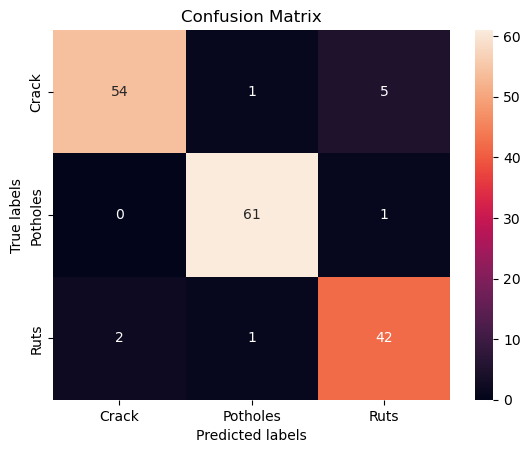

In [154]:
confusion_mat(vgg_model)

In [121]:
mobnet_model.save(os.path.join('models','MobNet_model_3classes.h5'))
resnet_model.save(os.path.join('models','ResNet_model_3classes.h5'))
vgg_model.save(os.path.join('models', 'VGG_model_3classes.h5'))

/Users/miss_viktoriia/make_tensor_work/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


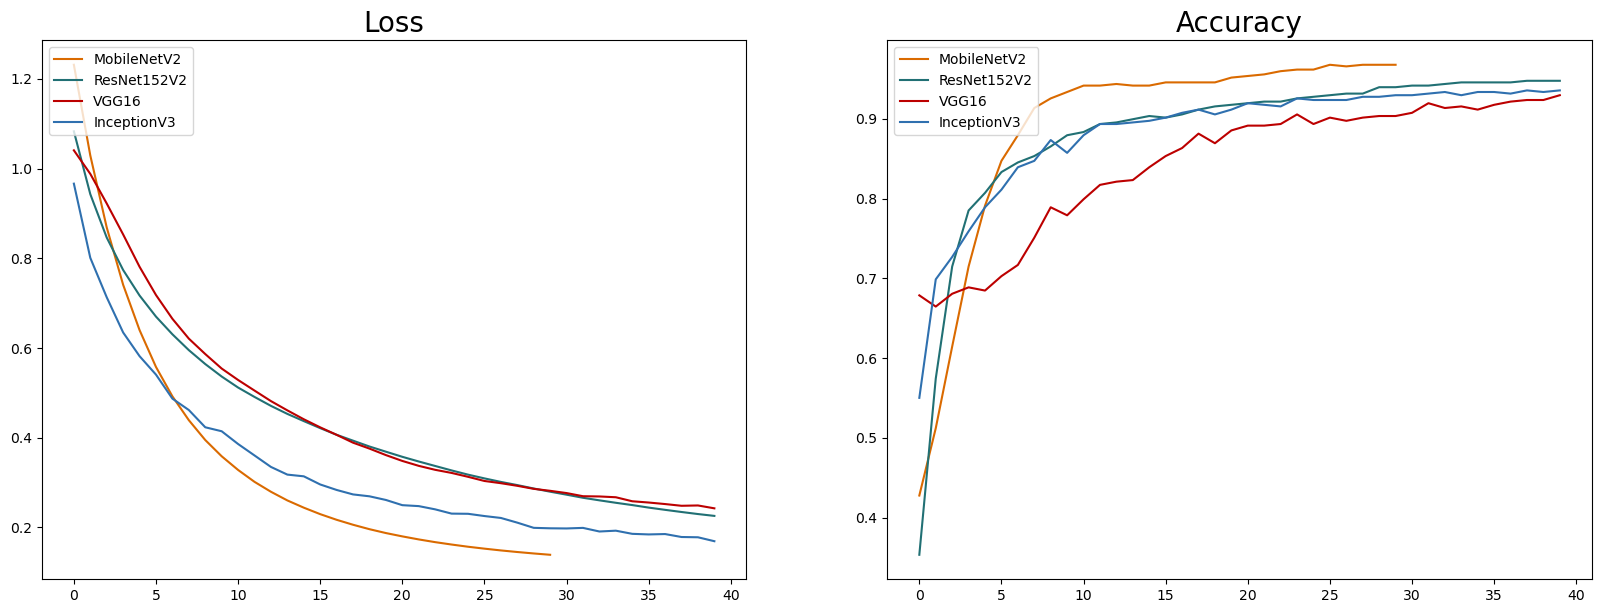

In [155]:
fig = plt.figure(figsize = [20,7])
fig.add_subplot(1,2,1); 
plt.plot(history_mobnet.history['val_loss'], color='#DA6A00', label='MobileNetV2'); 
plt.plot(history_resnet.history['val_loss'], color='#217074', label='ResNet152V2'); 
plt.plot(history_vgg.history['val_loss'], color='#BC0000', label='VGG16');
plt.plot(history_incept.history['val_loss'], color='#2F70AF', label='InceptionV3');
plt.legend(loc="upper left"); 
plt.title('Loss', fontsize=20);
fig.add_subplot(1,2,2); 
plt.plot(history_mobnet.history['val_accuracy'], color='#DA6A00', label='MobileNetV2'); 
plt.plot(history_resnet.history['val_accuracy'], color='#217074', label='ResNet152V2'); 
plt.plot(history_vgg.history['val_accuracy'], color='#BC0000', label='VGG16');
plt.plot(history_incept.history['val_accuracy'], color='#2F70AF', label='InceptionV3');
plt.legend(loc="upper left"); 
plt.title('Accuracy', fontsize=20);
plt.show()